# ARIMA models

Autoregressive Integrated Moving Average (ARIMA) models are a class of statistical models that try to explain the behavior of a time series using its own past values. Being a class of models, ARIMA models are defined by a set of parameters (p,d,q), each one corresponding to a different component of the ARIMA model.

<a id="importing"></a>
## Importing libraries and packages

In [1]:
# Warnings
import warnings

# Mathematical operations and data manipulation
import pandas as pd

# Models
from pmdarima import auto_arima

# Statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

<a id="set-paths"></a>
## Set paths

In [2]:
# Path to datasets directory
data_path = "./datasets"
# Path to assets directory (for saving results to)
assets_path = "./assets"

<a id="loading-data"></a>
## Loading dataset

In [3]:
# load hourly data
dataset = pd.read_csv(f"{data_path}/preprocessed_hour.csv")
dataset.head()

instant      dteday  season    yr  mnth  hr  holiday   weekday  workingday  \
0        1  2011-01-01  winter  2011     1   0        0  Saturday           0   
1        2  2011-01-01  winter  2011     1   1        0  Saturday           0   
2        3  2011-01-01  winter  2011     1   2        0  Saturday           0   
3        4  2011-01-01  winter  2011     1   3        0  Saturday           0   
4        5  2011-01-01  winter  2011     1   4        0  Saturday           0   

  weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0      clear  0.24  0.2879  81.0        0.0       3          13   16  
1      clear  0.22  0.2727  80.0        0.0       8          32   40  
2      clear  0.22  0.2727  80.0        0.0       5          27   32  
3      clear  0.24  0.2879  75.0        0.0       3          10   13  
4      clear  0.24  0.2879  75.0        0.0       0           1    1

In [4]:
# print some generic statistics about the data
print(f"Shape of data: {dataset.shape}")
print(f"Number of missing values in the data: {dataset.isnull().sum().sum()}")

# get statistics on the numerical columns
dataset.describe().T

Shape of data: (17379, 17)
Number of missing values in the data: 0


count         mean          std      min        25%        50%  \
instant     17379.0  8690.000000  5017.029500     1.00  4345.5000  8690.0000   
yr          17379.0  2011.502561     0.500008  2011.00  2011.0000  2012.0000   
mnth        17379.0     6.537775     3.438776     1.00     4.0000     7.0000   
hr          17379.0    11.546752     6.914405     0.00     6.0000    12.0000   
holiday     17379.0     0.028770     0.167165     0.00     0.0000     0.0000   
workingday  17379.0     0.682721     0.465431     0.00     0.0000     1.0000   
temp        17379.0     0.496987     0.192556     0.02     0.3400     0.5000   
atemp       17379.0     0.475775     0.171850     0.00     0.3333     0.4848   
hum         17379.0    62.722884    19.292983     0.00    48.0000    63.0000   
windspeed   17379.0    12.736540     8.196795     0.00     7.0015    12.9980   
casual      17379.0    35.676218    49.305030     0.00     4.0000    17.0000   
registered  17379.0   153.786869   151.357286     0.00    34.0000   115.0000   
cnt         17379.0   189.463088   181.387599     1.00    40.0000   142.0000   

                   75%         max  
instant     13034.5000  17379.0000  
yr           2012.0000   2012.0000  
mnth           10.0000     12.0000  
hr             18.0000     23.0000  
holiday         0.0000      1.0000  
workingday      1.0000      1.0000  
temp            0.6600      1.0000  
atemp           0.6212      1.0000  
hum            78.0000    100.0000  
windspeed      16.9979     56.9969  
casual         48.0000    367.0000  
registered    220.0000    886.0000  
cnt           281.0000    977.0000

<a id="preprocessing"></a>
## Preprocessing

In [5]:
# get daily rides
daily_rides = dataset[["dteday", "registered", "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()

# convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)

In [6]:
# make time series stationary
registered = daily_rides["registered"]
registered_ma = registered.rolling(10).mean()
registered_ma_diff = registered - registered_ma
registered_ma_diff.dropna(inplace=True)

casual = daily_rides["casual"]
casual_ma = casual.rolling(10).mean()
casual_ma_diff = casual - casual_ma
casual_ma_diff.dropna(inplace=True)

<a id="plots"></a>
## ACF and PACF plots for registered rides

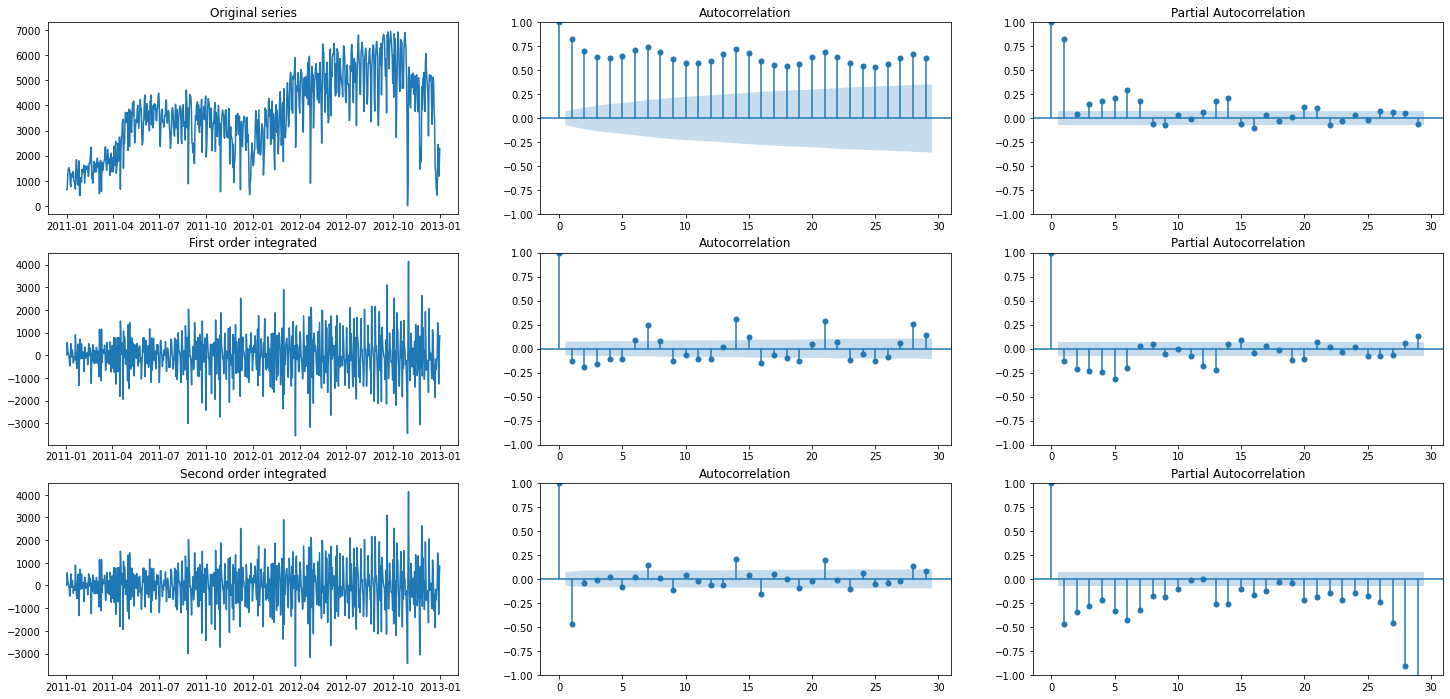

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))

# Plotting original series
original = daily_rides["registered"]
axes[0, 0].plot(original)
axes[0, 0].set_title("Original series")
plot_acf(original, ax=axes[0, 1])
plot_pacf(original, ax=axes[0, 2])

# Plotting first order integrated series
first_order_int = original.diff().dropna()
axes[1, 0].plot(first_order_int)
axes[1, 0].set_title("First order integrated")
plot_acf(first_order_int, ax=axes[1, 1])
plot_pacf(first_order_int, ax=axes[1, 2])

# Plotting first order integrated series
second_order_int = first_order_int.diff().dropna()
axes[2, 0].plot(first_order_int)
axes[2, 0].set_title("Second order integrated")
plot_acf(second_order_int, ax=axes[2, 1])
plot_pacf(second_order_int, ax=axes[2, 2])

fig.savefig(f"{assets_path}/acf_pacf.png", format="png")

In [8]:
# Fitting an ARIMA model to the registered rides
model = auto_arima(
    registered,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    information_criterion="aic",
)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5854.491
Date:                Sun, 20 Mar 2022   AIC                          11722.982
Time:                        21:28:04   BIC                          11755.133
Sample:                             0   HQIC                         11735.386
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6077      0.050     32.421      0.000       1.511       1.705
ar.L2         -1.4474      0.062    -23.372      0.000      -1.569      -1.326
ar.L3          0.3608      0.049      7.396      0.0

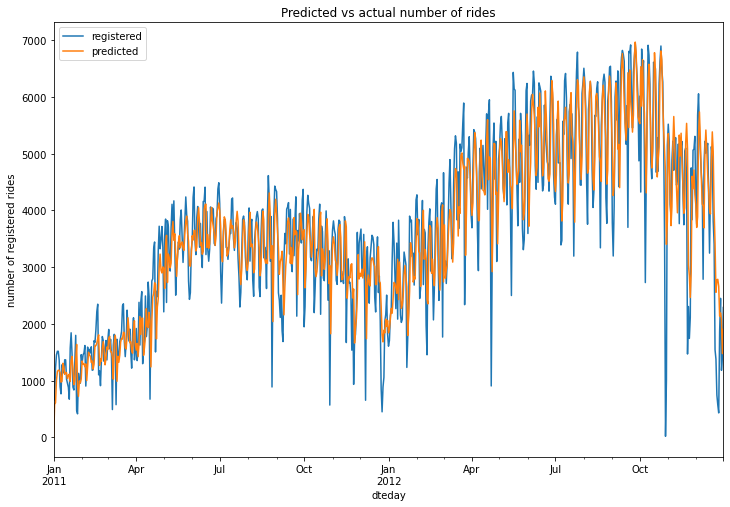

In [9]:
# plot original and predicted values
plot_data = pd.DataFrame(registered)
plot_data["predicted"] = model.predict_in_sample()
plot_data.plot(figsize=(12, 8))
plt.ylabel("number of registered rides")
plt.title("Predicted vs actual number of rides")
plt.savefig(f"{assets_path}/registered_arima_fit.png", format="png")